## ViT is composed of:
1. patch + position embedding
2. encoder
3. classification head

In [25]:
import os
import copy
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
# from torch import Tensor
import torch.nn as nn
import torch.optim as optim
# from torch.optim import lr_scheduler
from torchvision import datasets, transforms
# import torchvision.datasets as dset
# import torchvision.transforms as T
# from torchvision.transforms import Compose, Resize, ToTensor
# from torch.utils.data import DataLoader
# from torch.utils.data import sampler
from torchsummary import summary
from tqdm import tqdm
import einops
# from einops import rearrange, repeat, reduce
# from einops.layers.torch import Rearrange, Reduce

In [26]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [27]:
dtype = torch.long

In [28]:
# dataset

transform = transforms.Compose([transforms.ToTensor()])

mnist_train = datasets.MNIST(root='./mnist/',
                             train=True,
                             transform=transform,
                             download=True)
mnist_test = datasets.MNIST(root='./mnist/',
                            train=False,
                            transform=transform,
                            download=True)

print(mnist_train)
print(mnist_test)

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./mnist/
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
           )
Dataset MNIST
    Number of datapoints: 10000
    Root location: ./mnist/
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
           )


torch.Size([1, 1, 28, 28])

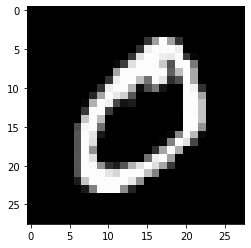

In [29]:
x = mnist_train[1][0]
plt.imshow(x[0], cmap='gray')

x = x.unsqueeze(0) # add batch dim
x.size()

## Patch + Position Embedding

divide the image into patches

In [30]:
class image_embedding(nn.Module):
    
    def __init__(self, 
                 in_channels: int=3, 
                 img_size: int=224, 
                 patch_size: int=16, 
                 emb_dim: int=16*16*3):
        # emb_dim: dim of propagating vector
        
        super().__init__()
        
        self.rearrange = einops.layers.torch.Rearrange('b c (num_w p1) (num_h p2) -> b (num_w num_h) (p1 p2 c)', p1=patch_size, p2=patch_size)
        
        self.linear = nn.Linear(in_channels * patch_size * patch_size, emb_dim)
        
        self.cls_token = nn.Parameter(torch.randn(1, 1, emb_dim))
        
        n_patches = img_size**2 // patch_size**2
        self.positions = nn.Parameter(torch.randn(n_patches+1, emb_dim))
        
    def forward(self, x):
        
        batch, channel, width, height = x.shape
        
        x = self.rearrange(x)
        
        x = self.linear(x)
        
        c = einops.repeat(self.cls_token, '() n d -> b n d', b=batch)
        x = torch.cat((c, x), dim=1)
        
        x = x + self.positions
        
        return x
        
emb = image_embedding(1, 28, 4, 4*4)(x)
emb.shape


torch.Size([1, 50, 16])

## Encoder

In [41]:
class multi_head_attention(nn.Module):
    
    def __init__(self, 
                 emb_dim: int=16*16*3, 
                 num_heads: int=8, 
                 dropout_ratio: float=0.2, 
                 verbose=False, 
                 **kwargs):
        
        super().__init__()
        
        self.v = verbose
        
        self.emb_dim = emb_dim
        self.num_heads = num_heads
        self.scaling = (self.emb_dim//num_heads) ** -0.5
        
        # q, k, v
        self.query = nn.Linear(emb_dim, emb_dim)
        self.key = nn.Linear(emb_dim, emb_dim)        
        self.value = nn.Linear(emb_dim, emb_dim)
        
        self.att_drop = nn.Dropout(dropout_ratio)
        
        self.linear = nn.Linear(emb_dim, emb_dim)
        
    def forward(self, x: Tensor):
        
        # q, k, v
        Q = self.query(x)
        K = self.key(x)
        V = self.value(x)
        if self.v: 
            print(f'Q, K, V: {Q.size(), K.size(), V.size()}')
            
        # q, k, v rearranged
        Q = einops.rearrange(Q, 'b q (h d) -> b h q d', h=self.num_heads)
        K = einops.rearrange(K, 'b k (h d) -> b h d k', h=self.num_heads)
        V = einops.rearrange(V, 'b v (h d) -> b h v d', h=self.num_heads)
        if self.v:
            print(f'Q, K, V rearranged: {Q.size(), K.size(), V.size()}')
        
        # scaled dot-product
        weight = torch.matmul(Q, K)
        weight = weight * self.scaling
        if self.v:
            print(f'weight: {weight.size()}')
            
        attention = torch.softmax(weight, dim=-1)
        attention = self.att_drop(attention)
        if self.v:
            print(f'attention: {attention.size()}')

        context = torch.matmul(attention, V)
        context = einops.rearrange(context, 'b h q d -> b q (h d)')
        if self.v:
            print(f'context: {context.size()}')
            
        x = self.linear(context)
        return x, attention
        
feat, attention = multi_head_attention(4*4, 4, verbose=True)(emb)
print(f'feat: {feat.shape}')
print(f'attention: {attention.shape}')
        

Q, K, V: (torch.Size([1, 50, 16]), torch.Size([1, 50, 16]), torch.Size([1, 50, 16]))
Q, K, V rearranged: (torch.Size([1, 4, 50, 4]), torch.Size([1, 4, 4, 50]), torch.Size([1, 4, 50, 4]))
weight: torch.Size([1, 4, 50, 50])
attention: torch.Size([1, 4, 50, 50])
context: torch.Size([1, 50, 16])
feat: torch.Size([1, 50, 16])
attention: torch.Size([1, 4, 50, 50])


In [40]:
class mlp_block(nn.Module):
    def __init__(self, 
                 emb_dim: int=16*16*3, 
                 forward_dim: int=4, 
                 dropout_ratio: float=0.2, 
                 **kwargs):
        
        super().__init__()
        
        self.linear_1 = nn.Linear(emb_dim, forward_dim*emb_dim)
        self.dropout = nn.Dropout(dropout_ratio)
        self.linear_2 = nn.Linear(forward_dim*emb_dim, emb_dim)
        
    def forward(self, x):
        x = self.linear_1(x)
        x = nn.functional.gelu(x)
        x = self.dropout(x)
        x = self.linear_2(x)
        return x

In [43]:
class encoder_block(nn.Sequential):
    
    def __init__(self, 
                 emb_dim: int=16*16*3, 
                 num_heads: int=8, 
                 forward_dim: int=4, 
                 dropout_ratio: float=0.2):
        
        super().__init__()
        
        self.norm_1 = nn.LayerNorm(emb_dim)
        self.mha = multi_head_attention(emb_dim, num_heads, dropout_ratio)
        
        self.norm_2 = nn.LayerNorm(emb_dim)
        self.mlp = mlp_block(emb_dim, forward_dim, dropout_ratio)
        
        self.residual_dropout = nn.Dropout(dropout_ratio)
        
    def forward(self, x):
        
        x_ = self.norm_1(x)
        x_, attention = self.mha(x_)
        x = x_ + self.residual_dropout(x)
        
        x_ = self.norm_2(x)
        x_ = self.mlp(x_)
        x = x_ + self.residual_dropout(x)
        
        return x, attention
    
feat, attention = encoder_block(4*4, 2, 4)(emb)
print(f'feat: {feat.shape}')
print(f'attention: {attention.shape}')


feat: torch.Size([1, 50, 16])
attention: torch.Size([1, 2, 50, 50])


## Model

In [44]:
class vision_transformer(nn.Module):
    
    def __init__(self, 
                 in_channel: int=3, 
                 img_size: int=224, 
                 patch_size: int=16, 
                 emb_dim: int=16*16*3, 
                 n_enc_layers: int=15, 
                 num_heads: int=3, 
                 forward_dim: int=4, 
                 dropout_ratio: float=0.2, 
                 n_classes: int=1000):
        
        super().__init__()
        
        # image embedding
        self.image_emb = image_embedding(in_channel, img_size, patch_size, emb_dim)
        # N times of encoder layer
        self.transformer_encoders = nn.ModuleList([encoder_block(emb_dim, num_heads, forward_dim, dropout_ratio) for _ in range(n_enc_layers)])
        
        self.reduce_layer = einops.layers.torch.Reduce('b n e -> b e', reduction='mean')
        self.normalization = nn.LayerNorm(emb_dim)
        self.classification_head = nn.Linear(emb_dim, n_classes)
        
    def forward(self, x):
        
        # image embedding
        x = self.image_emb(x)
        
        # transformer encoder
        attentions = []
        for encoder in self.transformer_encoders:
            x, attention = encoder(x)
            attentions.append(attention)
            
        # classification head
        x = self.reduce_layer(x)
        x = self.normalization(x)
        x = self.classification_head(x)
        
        return x, attentions
    
y, attentions = vision_transformer(1, 28, 4, 4*4, 3, 2, 4, 0.2, 10)(x)
print(y.shape)
print(attentions[0].shape)
    

torch.Size([1, 10])
torch.Size([1, 2, 50, 50])


## Performance

In [47]:
model = vision_transformer(1, 28, 4, 4*4, 3, 2, 4, 0.2, 10)
model.to(device)

num_epochs = 10
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

batch_size = 64
dataloaders_train = torch.utils.data.DataLoader(mnist_train, batch_size=batch_size, sampler=torch.utils.data.sampler.SubsetRandomSampler(range(0, len(mnist_train) * 4//5)))
dataloaders_valid = torch.utils.data.DataLoader(mnist_train, batch_size=batch_size, sampler=torch.utils.data.sampler.SubsetRandomSampler(range(len(mnist_train) * 4//5, len(mnist_train))))
dataloaders_test = torch.utils.data.DataLoader(mnist_test, batch_size=batch_size)

In [48]:
for epoch in range(num_epochs):
    print(f'epoch {epoch}:')
    
    
    # training
    model.train()
    running_loss = 0.
    running_acc = 0.
    
    for idx, (inputs, labels) in tqdm(enumerate(dataloaders_train)):
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        
        with torch.set_grad_enabled(True):
            
            outputs, _ = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            loss = criterion(outputs, labels)
            
            loss.backward()
            
            optimizer.step()
            
            running_loss += loss.item() * inputs.shape[0]
            running_acc += torch.sum(preds==labels.data)
            
    running_acc /= (idx+1) * batch_size
        
    print(f'\ttrain \n\t\tloss: {running_loss} acc: {running_acc}')
    
    
    # validation
    model.eval()
    running_acc = 0.
    
    for idx, (inputs, labels) in tqdm(enumerate(dataloaders_valid)):
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        with torch.set_grad_enabled(False):
            
            outputs, _ = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            running_acc += torch.sum(preds==labels.data)

    running_acc /= (idx+1) * batch_size
    
    print(f'\tvalid \n\t\tacc: {running_acc}')
    

epoch 0:


750it [00:38, 19.44it/s]


	train 
		loss: 89423.0696105957 acc: 0.31466665863990784


188it [00:03, 56.71it/s]


	valid 
		acc: 0.5813663601875305
epoch 1:


750it [00:38, 19.35it/s]


	train 
		loss: 48264.63979721069 acc: 0.6472708582878113


188it [00:03, 55.29it/s]


	valid 
		acc: 0.7546542286872864
epoch 2:


750it [00:40, 18.41it/s]


	train 
		loss: 34597.15810394287 acc: 0.7620000243186951


188it [00:03, 49.09it/s]


	valid 
		acc: 0.8431681990623474
epoch 3:


750it [00:38, 19.47it/s]


	train 
		loss: 27321.076278686523 acc: 0.8152916431427002


188it [00:03, 57.58it/s]


	valid 
		acc: 0.868517279624939
epoch 4:


750it [00:38, 19.66it/s]


	train 
		loss: 23302.260655403137 acc: 0.8450208306312561


188it [00:03, 57.77it/s]


	valid 
		acc: 0.8847240805625916
epoch 5:


750it [00:40, 18.69it/s]


	train 
		loss: 20526.990516662598 acc: 0.8652083277702332


188it [00:03, 51.11it/s]


	valid 
		acc: 0.8994348645210266
epoch 6:


750it [00:38, 19.64it/s]


	train 
		loss: 18902.478529930115 acc: 0.8768125176429749


188it [00:03, 57.58it/s]


	valid 
		acc: 0.9006814956665039
epoch 7:


750it [00:39, 18.75it/s]


	train 
		loss: 17327.31916475296 acc: 0.8851458430290222


188it [00:03, 56.84it/s]


	valid 
		acc: 0.9169713854789734
epoch 8:


750it [00:39, 19.05it/s]


	train 
		loss: 16385.297647953033 acc: 0.8926874995231628


188it [00:03, 56.39it/s]


	valid 
		acc: 0.9194647669792175
epoch 9:


750it [00:39, 18.99it/s]


	train 
		loss: 15316.917495250702 acc: 0.898812472820282


188it [00:03, 56.31it/s]

	valid 
		acc: 0.9230385422706604


In [50]:
model.eval()
running_acc = 0.

for idx, (inputs, labels) in tqdm(enumerate(dataloaders_test)):
    inputs = inputs.to(device)
    labels = labels.to(device)
    
    with torch.set_grad_enabled(False):
        
        outputs, _ = model(inputs)
        _, preds = torch.max(outputs, 1)
        
        running_acc += torch.sum(preds==labels.data)
        
running_acc /= (idx+1) * batch_size

print(f'acc: {running_acc}')

157it [00:02, 57.32it/s]

acc: 0.9198845624923706


## Visualization

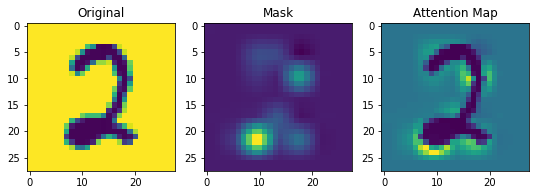

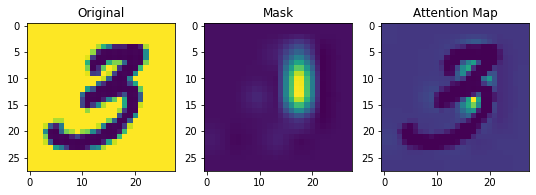

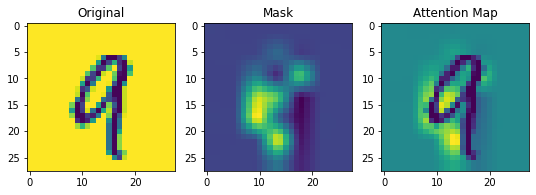

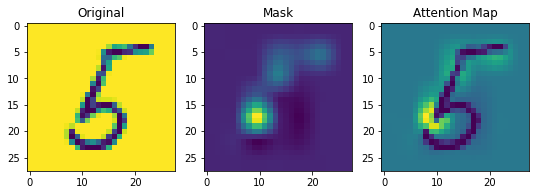

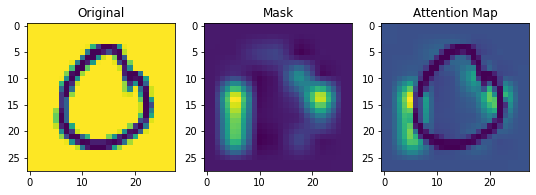

In [54]:
idxs = np.random.choice(range(len(mnist_test.data)), 5, False)

for idx in idxs:
    img = mnist_test.data[idx]
    img = 255 - img
    
    _, attentions = model(img.unsqueeze(0).unsqueeze(1).to(device, torch.float))
    
    # Average the attention weights across all heads.
    att_mat = torch.stack(attentions).squeeze(1)
    att_mat = att_mat.cpu().detach()
    att_mat = einops.reduce(att_mat, 'b h len1 len2 -> b len1 len2', 'mean')

    residual_att = torch.eye(att_mat.size(1))
    aug_att_mat = att_mat + residual_att
    aug_att_mat = aug_att_mat / aug_att_mat.sum(dim=-1).unsqueeze(-1)

    # Recursively multiply the weight matrices
    joint_attentions = torch.zeros(aug_att_mat.size())
    joint_attentions[0] = aug_att_mat[0]

    for n in range(1, aug_att_mat.size(0)):
        joint_attentions[n] = torch.matmul(aug_att_mat[n], joint_attentions[n-1])

    # Attention from the output token to the input space.
    v = joint_attentions[-1]
    grid_size = int(np.sqrt(aug_att_mat.size(-1)))
    mask = v[0, 1:].reshape(grid_size, grid_size).detach().numpy()
    mask = cv2.resize(mask/mask.max(), (img.shape[1], img.shape[0]))[..., np.newaxis]
    mask = mask.squeeze()
    result = (mask * img.numpy()).astype("uint8")

    # plotting
    fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(9, 3)) 
    ax1.set_title('Original')
    ax2.set_title('Mask')
    ax3.set_title('Attention Map')
    _ = ax1.imshow(img)
    _ = ax2.imshow(mask)
    _ = ax3.imshow(result)